In [133]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelBinarizer
import datetime

In [135]:
#カテゴリー、通貨、国、ゴールの大きさ、ローンチ、デッドライン　くらいしか事前推定の要素として使えない。
#ローンチからデッドラインまでの日数は有効かもしれない。またゴールをその日数で割るというのも、1日あたりの獲得金額を表現でき、有効かもしれない。

df_deals = pd.read_csv("./kickstarter-projects/ks-projects-201801.csv")[['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']]
display(df_deals.head())
data_records_count = len(df_deals['ID'])

#stateをフラグ化。
state_flag = np.array([])
state_flag = df_deals['state'].values
#不的確なデータレコードを削除しても、DataFrameの枠組みで行うと、要素番号がずれずに空欄になってしまうため、誤作動につながる。
#そのため、今はデータレコード削除していない。
#delete_row = []
#for k in range(len(state_flag)):
#    if state_flag[k] =='live' or state_flag[k] =='undefined':
#        delete_row.append(k)
#if len(delete_row) >0:
#    df_deals.drop(delete_row, axis=0, inplace=True)
#    data_records_count = data_records_count - len(delete_row)
df_deals['state'] = (df_deals['state'] == 'successful')*1
#（USDだけを対象にしてみるか？）

#CurrencyをUSD or notでフラグ化。
currencyUSD_flag = np.array([])
df_deals['currency'] = (df_deals['currency'] == 'USD')*1

#main_categoryをOne Hot Dataへ。
lb = LabelBinarizer()
onehot_main_category = lb.fit_transform(df_deals['main_category'])

#ローンチからデッドラインまでの日数、および1日あたり目標金額を計算し新たな説明変数へ。
fundingspan = np.array([])
dailyfundingtarget = np.array([])
for i in range(data_records_count):
#不的確なデータレコードを削除しても、DataFrameの枠組みで行うと、要素番号がずれずに空欄になってしまうため、誤作動につながる。
#そのため、今はデータレコード削除していない。
    launched_datedata = datetime.datetime.strptime(df_deals['launched'][i], '%Y-%m-%d %H:%M:%S')
    deadline_datedata = datetime.datetime.strptime(df_deals['deadline'][i], '%Y-%m-%d')
    dayspan = (deadline_datedata - launched_datedata).days
    fundingspan = np.append(fundingspan, dayspan)
    if dayspan >0:
        dailyfundingtarget = np.append(dailyfundingtarget, df_deals['goal'][i]/dayspan)
    else:
        dailyfundingtarget = np.append(dailyfundingtarget, df_deals['goal'][i])


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


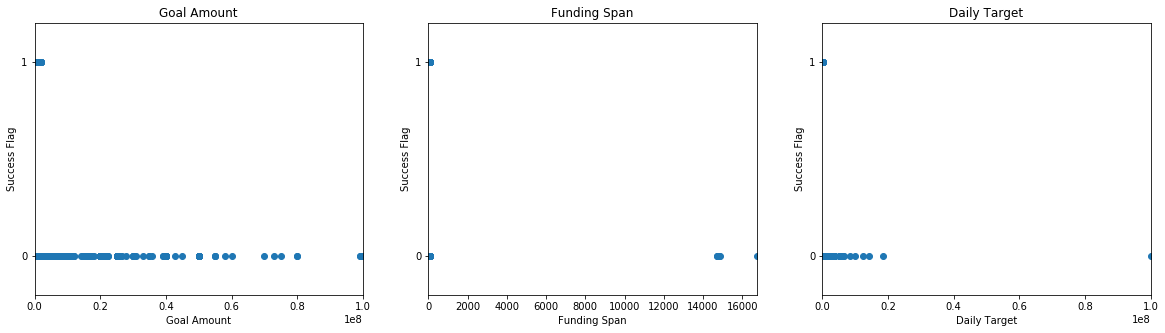

currency,0,1
main_category,,
Art,0.344745,0.425620
Comics,0.535359,0.540965
Crafts,0.219806,0.246691
Dance,0.463822,0.646640
Design,0.342404,0.354110
Fashion,0.236475,0.248387
Film & Video,0.347416,0.376577
Food,0.157725,0.268278
Games,0.298527,0.379723


In [136]:
y = df_deals['state'].values

#各種グラフ描画
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Goal Amount')
ax1.set_xlabel("Goal Amount")
ax1.set_ylabel("Success Flag")
x = df_deals['goal'].values
ax1.set_yticks([0,1])
ax1.scatter(x,y, color='C0')
ax1.set_xlim([np.min(x) - 1, np.max(x) + 1])
ax1.set_ylim([-0.2, 1.2])

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Funding Span')
ax2.set_xlabel("Funding Span")
ax2.set_ylabel("Success Flag")
x = fundingspan
ax2.set_yticks([0,1])
ax2.scatter(x,y, color='C0')
ax2.set_xlim([-1, np.max(x) + 1])
ax2.set_ylim([-0.2, 1.2])

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Daily Target')
ax3.set_xlabel("Daily Target")
ax3.set_ylabel("Success Flag")
x = dailyfundingtarget
ax3.set_yticks([0,1])
ax3.scatter(x,y, color='C0')
ax3.set_xlim([-1, np.max(x) + 1])
ax3.set_ylim([-0.2, 1.2])

plt.show()

#ゼロかイチをとるフラグの平均を求めると、そのセグメントにおける成功率がわかる。
pd.pivot_table(df_deals, values='state', index='main_category', columns='currency', aggfunc='mean')


w0 = 28974.325, w1 = 739757.112, w2 = -43423.796


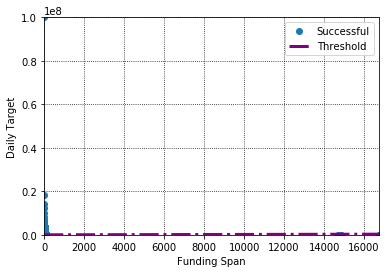

対数尤度 = -17.442
正答率 = 49.502%
適合率 = 76.805%
再現率 = 31.317%
F1値 = 44.492%


,予測 = 調達失敗,予測 = 調達成功
正解 = 調達失敗,76634,168071
正解 = 調達成功,23144,110812


In [137]:
#ロジスティック回帰
#散布図の結果を踏まえたわけではないが、一旦Funding SpanとDaily Targetを説明変数に採用してみる。
fundingspan_T = fundingspan.reshape(-1,1)
dailyfundingtarget_T = dailyfundingtarget.reshape(-1,1)
X = np.c_[fundingspan_T, dailyfundingtarget_T]
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

x1 = fundingspan
x2 = dailyfundingtarget
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(x1, x2, 'o', color='C0', label='Successful')
#サクセスと失敗で色分けできてない。
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.xlim([np.min(x1) - 1, np.max(x1) + 1])
plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.legend(loc='best')
plt.xlabel("Funding Span")
plt.ylabel("Daily Target")
plt.show()

y_est = clf.predict(X)
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
precision, recall, f1_score, _ = precision_recall_fscore_support(y,y_est)
print('適合率 = {:.3f}%'.format(100 * precision[0]))
print('再現率 = {:.3f}%'.format(100 * recall[0]))
print('F1値 = {:.3f}%'.format(100 * f1_score[0]))
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 調達失敗', '正解 = 調達成功'], 
                        columns=['予測 = 調達失敗', '予測 = 調達成功'])
display(conf_mat)
